In [2]:
#データ加工でよく使うやつ
import datetime  # 日付,時刻の処理
import yaml  # yamlファイル操作
import re  # 正規表現操作
import shutil  # ファイル操作
import glob  # ファイル操作
import os  # ファイル操作
import pickle
import seaborn as sns  # グラフ描画
import pandas as pd  # データ加工入出力,DataFlame
import numpy as np  # 行列計算
import scipy as sp  # 科学技術計算
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

#モデリング
from sklearn.model_selection import train_test_split # 訓練データとテストデータの分割を行うライブラリ
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc  # 評価指標
# KFold交差検証のライブラリ、交差検証のスコアを求めるライブラリ、および交差検証による予測に関するライブラリをimport
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

In [3]:
df_test_pitch = pd.read_csv('../yakiu_rawdata/test_pitch.csv')
df_test_player = pd.read_csv('../yakiu_rawdata/test_player.csv')
df_train_pitch = pd.read_csv('../yakiu_rawdata/train_pitch.csv')
df_train_player = pd.read_csv('../yakiu_rawdata/train_player.csv')
df_sample = pd.read_csv('../yakiu_rawdata/sample_submit_ball_type.csv')

In [4]:
len(df_test_pitch)

521650

In [5]:
len(df_train_pitch)

257117

- testデータとTrainデータをマージしてから加工する。加工完了したのち分割する。

In [6]:
# test_pitchデータ加工。球種列のダミーを作成。
a = pd.DataFrame(np.nan, index = np.arange(len(df_test_pitch)), columns = ['球種'])
df_test_pitch = pd.concat([a,df_test_pitch],axis=1)

In [7]:
# 投球位置区域はもう一方のコンペでのみ使用のため、今回はdrop
df_train_pitch = df_train_pitch.drop('投球位置区域', axis=1)

In [8]:
# pitchデータをマージ
df_pitch_merge = pd.concat([df_train_pitch,df_test_pitch],axis=0)

In [9]:
# playerデータをマージ
df_player_merge = pd.concat([df_train_player,df_test_player],axis=0)

# プレイデータの加工

In [10]:
df_train_pitch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257117 entries, 0 to 257116
Data columns (total 50 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   データ内連番          257117 non-null  int64  
 1   球種              257117 non-null  int64  
 2   年度              257117 non-null  int64  
 3   試合ID            257117 non-null  int64  
 4   試合内連番           257117 non-null  int64  
 5   試合内投球数          257117 non-null  int64  
 6   日付              257117 non-null  object 
 7   時刻              257117 non-null  object 
 8   ホームチームID        257117 non-null  int64  
 9   アウェイチームID       257117 non-null  int64  
 10  球場ID            257117 non-null  int64  
 11  球場名             257117 non-null  object 
 12  試合種別詳細          257117 non-null  object 
 13  イニング            257117 non-null  int64  
 14  表裏              257117 non-null  object 
 15  イニング内打席数        257117 non-null  int64  
 16  打席内投球数          257117 non-null  int64  
 17  投手ID      

In [11]:
df_pitch =  df_pitch_merge.drop(['一塁手ID','二塁手ID','三塁手ID','遊撃手ID','左翼手ID','中堅手ID','左翼手ID'], axis=1)

In [12]:
df_pitch['count'] = df_pitch[['プレイ前ストライク数', 'プレイ前ボール数', 'プレイ前アウト数']].apply(lambda x: '{}-{}-{}'.format(x[0], x[1], x[2]), axis=1)

In [13]:
df_pitch['count']

0         0-0-0
1         1-0-0
2         2-0-0
3         0-0-1
4         1-0-1
          ...  
521645    2-1-1
521646    0-0-2
521647    1-0-2
521648    2-0-2
521649    2-1-2
Name: count, Length: 778767, dtype: object

In [14]:
h = df_pitch.query('表裏=="表"')
h['pitch_team_score'] = h['プレイ前アウェイチーム得点数']-h['プレイ前ホームチーム得点数']
a = df_pitch.query('表裏=="裏"')
a['pitch_team_score'] = a['プレイ前ホームチーム得点数']-a['プレイ前アウェイチーム得点数']
df_pitch = pd.concat([h,a],axis=0)
df_pitch =df_pitch.sort_values(['年度','データ内連番'])
df_pitch

C:\Users\bono_\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\bono_\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,データ内連番,球種,年度,試合ID,試合内連番,試合内投球数,日付,時刻,ホームチームID,アウェイチームID,球場ID,球場名,試合種別詳細,イニング,表裏,イニング内打席数,打席内投球数,投手ID,投手チームID,投手投球左右,投手役割,投手登板順,投手試合内対戦打者数,投手試合内投球数,投手イニング内投球数,打者ID,打者チームID,打者打席左右,打者打順,打者守備位置,打者試合内打席数,プレイ前ホームチーム得点数,プレイ前アウェイチーム得点数,プレイ前アウト数,プレイ前ボール数,プレイ前ストライク数,プレイ前走者状況,一塁走者ID,二塁走者ID,三塁走者ID,捕手ID,右翼手ID,成績対象投手ID,成績対象打者ID,count,pitch_team_score
0,0,0.0,2017,2017033101,1,1,2017-03-31,18:03:00,1,4,1,東京ドーム,セ・リーグ公式戦,1,表,1,1,1500001,1,右,先発,1,1,1,1,900410,4,左,1,中,1,0,0,0,0,0,___,NaN,NaN,NaN,1300027,900397,1500001,900410,0-0-0,0
1,1,0.0,2017,2017033101,2,2,2017-03-31,18:03:12,1,4,1,東京ドーム,セ・リーグ公式戦,1,表,1,2,1500001,1,右,先発,1,1,2,2,900410,4,左,1,中,1,0,0,0,0,1,___,NaN,NaN,NaN,1300027,900397,1500001,900410,1-0-0,0
2,2,0.0,2017,2017033101,3,3,2017-03-31,18:03:23,1,4,1,東京ドーム,セ・リーグ公式戦,1,表,1,3,1500001,1,右,先発,1,1,3,3,900410,4,左,1,中,1,0,0,0,0,2,___,NaN,NaN,NaN,1300027,900397,1500001,900410,2-0-0,0
3,3,0.0,2017,2017033101,4,4,2017-03-31,18:04:01,1,4,1,東京ドーム,セ・リーグ公式戦,1,表,2,1,1500001,1,右,先発,1,2,4,4,11436,4,右,2,二,1,0,0,1,0,0,___,NaN,NaN,NaN,1300027,900397,1500001,11436,0-0-1,0
4,4,0.0,2017,2017033101,5,5,2017-03-31,18:04:12,1,4,1,東京ドーム,セ・リーグ公式戦,1,表,2,2,1500001,1,右,先発,1,2,5,5,11436,4,右,2,二,1,0,0,1,0,1,___,NaN,NaN,NaN,1300027,900397,1500001,11436,1-0-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521645,521645,NaN,2019,2019093001,289,285,2019-09-30,21:10:05,5,4,5,甲子園,セ・リーグ公式戦,9,表,3,8,11807,5,右,救援,6,3,17,17,700034,4,右,4,一,2,3,0,1,1,2,_2_,NaN,1700103.0,NaN,1300073,1500086,11807,700034,2-1-1,-3
521646,521646,NaN,2019,2019093001,290,286,2019-09-30,21:10:53,5,4,5,甲子園,セ・リーグ公式戦,9,表,4,1,11807,5,右,救援,6,4,18,18,1100069,4,左,5,三,4,3,0,2,0,0,_2_,NaN,1700103.0,NaN,1300073,1500086,11807,1100069,0-0-2,-3
521647,521647,NaN,2019,2019093001,291,287,2019-09-30,21:11:21,5,4,5,甲子園,セ・リーグ公式戦,9,表,4,2,11807,5,右,救援,6,4,19,19,1100069,4,左,5,三,4,3,0,2,0,1,_2_,NaN,1700103.0,NaN,1300073,1500086,11807,1100069,1-0-2,-3
521648,521648,NaN,2019,2019093001,292,288,2019-09-30,21:12:05,5,4,5,甲子園,セ・リーグ公式戦,9,表,4,3,11807,5,右,救援,6,4,20,20,1100069,4,左,5,三,4,3,0,2,0,2,_2_,NaN,1700103.0,NaN,1300073,1500086,11807,1100069,2-0-2,-3


In [15]:
df_date =df_pitch['日付'].str.split('-', expand=True)
df_date

,0,1,2
0,2017,03,31
1,2017,03,31
2,2017,03,31
3,2017,03,31
4,2017,03,31
...,...,...,...
521645,2019,09,30
521646,2019,09,30
521647,2019,09,30
521648,2019,09,30


In [16]:
df_date.rename(columns={0: 'year', 1: 'month',2:'day'}, inplace=True)
df_date = df_date.loc[:,['month']]
df_date = df_date.astype({'month':int})
df_date.head()

,month
0,3
1,3
2,3
3,3
4,3


In [17]:
df_pitch = pd.concat([df_pitch,df_date],axis=1)

In [18]:
df_pitch.head(1)

,データ内連番,球種,年度,試合ID,試合内連番,試合内投球数,日付,時刻,ホームチームID,アウェイチームID,球場ID,球場名,試合種別詳細,イニング,表裏,イニング内打席数,打席内投球数,投手ID,投手チームID,投手投球左右,投手役割,投手登板順,投手試合内対戦打者数,投手試合内投球数,投手イニング内投球数,打者ID,打者チームID,打者打席左右,打者打順,打者守備位置,打者試合内打席数,プレイ前ホームチーム得点数,プレイ前アウェイチーム得点数,プレイ前アウト数,プレイ前ボール数,プレイ前ストライク数,プレイ前走者状況,一塁走者ID,二塁走者ID,三塁走者ID,捕手ID,右翼手ID,成績対象投手ID,成績対象打者ID,count,pitch_team_score,month
0,0,0.0,2017,2017033101,1,1,2017-03-31,18:03:00,1,4,1,東京ドーム,セ・リーグ公式戦,1,表,1,1,1500001,1,右,先発,1,1,1,1,900410,4,左,1,中,1,0,0,0,0,0,___,NaN,NaN,NaN,1300027,900397,1500001,900410,0-0-0,0,3


In [37]:
a = df_pitch.loc[:,['試合ID','投手ID','イニング']].groupby(['試合ID','投手ID']).min()
a = a.rename(columns={'イニング':'start_ining'})

In [39]:
df_pitch = pd.merge(df_pitch,a,on=['試合ID','投手ID'])

In [40]:
df_pitch_sum = pd.DataFrame(df_pitch.loc[:,['年度','投手ID']])
df_pitch_sum['N']=1
df_pitch_sum=df_pitch_sum.groupby(['年度','投手ID']).agg(np.cumsum)
df_pitch_sum

,N
0,1
1,2
2,3
3,4
4,5
...,...
778762,1001
778763,1002
778764,1003
778765,1004


In [41]:
df_pitch2 = pd.concat([df_pitch,df_pitch_sum],axis=1)
df_pitch2

,データ内連番,球種,年度,試合ID,試合内連番,試合内投球数,日付,時刻,ホームチームID,アウェイチームID,球場ID,球場名,試合種別詳細,イニング,表裏,イニング内打席数,打席内投球数,投手ID,投手チームID,投手投球左右,投手役割,投手登板順,投手試合内対戦打者数,投手試合内投球数,投手イニング内投球数,打者ID,打者チームID,打者打席左右,打者打順,打者守備位置,打者試合内打席数,プレイ前ホームチーム得点数,プレイ前アウェイチーム得点数,プレイ前アウト数,プレイ前ボール数,プレイ前ストライク数,プレイ前走者状況,一塁走者ID,二塁走者ID,三塁走者ID,捕手ID,右翼手ID,成績対象投手ID,成績対象打者ID,count,pitch_team_score,month,start_ining,N
0,0,0.0,2017,2017033101,1,1,2017-03-31,18:03:00,1,4,1,東京ドーム,セ・リーグ公式戦,1,表,1,1,1500001,1,右,先発,1,1,1,1,900410,4,左,1,中,1,0,0,0,0,0,___,NaN,NaN,NaN,1300027,900397,1500001,900410,0-0-0,0,3,1,1
1,1,0.0,2017,2017033101,2,2,2017-03-31,18:03:12,1,4,1,東京ドーム,セ・リーグ公式戦,1,表,1,2,1500001,1,右,先発,1,1,2,2,900410,4,左,1,中,1,0,0,0,0,1,___,NaN,NaN,NaN,1300027,900397,1500001,900410,1-0-0,0,3,1,2
2,2,0.0,2017,2017033101,3,3,2017-03-31,18:03:23,1,4,1,東京ドーム,セ・リーグ公式戦,1,表,1,3,1500001,1,右,先発,1,1,3,3,900410,4,左,1,中,1,0,0,0,0,2,___,NaN,NaN,NaN,1300027,900397,1500001,900410,2-0-0,0,3,1,3
3,3,0.0,2017,2017033101,4,4,2017-03-31,18:04:01,1,4,1,東京ドーム,セ・リーグ公式戦,1,表,2,1,1500001,1,右,先発,1,2,4,4,11436,4,右,2,二,1,0,0,1,0,0,___,NaN,NaN,NaN,1300027,900397,1500001,11436,0-0-1,0,3,1,4
4,4,0.0,2017,2017033101,5,5,2017-03-31,18:04:12,1,4,1,東京ドーム,セ・リーグ公式戦,1,表,2,2,1500001,1,右,先発,1,2,5,5,11436,4,右,2,二,1,0,0,1,0,1,___,NaN,NaN,NaN,1300027,900397,1500001,11436,1-0-1,0,3,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778762,521645,NaN,2019,2019093001,289,285,2019-09-30,21:10:05,5,4,5,甲子園,セ・リーグ公式戦,9,表,3,8,11807,5,右,救援,6,3,17,17,700034,4,右,4,一,2,3,0,1,1,2,_2_,NaN,1700103.0,NaN,1300073,1500086,11807,700034,2-1-1,-3,9,9,1001
778763,521646,NaN,2019,2019093001,290,286,2019-09-30,21:10:53,5,4,5,甲子園,セ・リーグ公式戦,9,表,4,1,11807,5,右,救援,6,4,18,18,1100069,4,左,5,三,4,3,0,2,0,0,_2_,NaN,1700103.0,NaN,1300073,1500086,11807,1100069,0-0-2,-3,9,9,1002
778764,521647,NaN,2019,2019093001,291,287,2019-09-30,21:11:21,5,4,5,甲子園,セ・リーグ公式戦,9,表,4,2,11807,5,右,救援,6,4,19,19,1100069,4,左,5,三,4,3,0,2,0,1,_2_,NaN,1700103.0,NaN,1300073,1500086,11807,1100069,1-0-2,-3,9,9,1003
778765,521648,NaN,2019,2019093001,292,288,2019-09-30,21:12:05,5,4,5,甲子園,セ・リーグ公式戦,9,表,4,3,11807,5,右,救援,6,4,20,20,1100069,4,左,5,三,4,3,0,2,0,2,_2_,NaN,1700103.0,NaN,1300073,1500086,11807,1100069,2-0-2,-3,9,9,1004


# playerファイルの加工
- 経験年数の列を作成
- 年齢の列を作成(早生まれも対応)
- 出身地域を3つに分ける

In [42]:
df_player = pd.DataFrame(df_player_merge)
df_player =df_player.reset_index(drop=True)

In [43]:
a = pd.DataFrame(range(0,len(df_player),1),columns=['No'])
df_player=pd.concat([a,df_player],axis=1)

In [44]:
df_player['経験年数'] = df_player['年度']-df_player['ドラフト年']

In [45]:
df_age = df_player['生年月日'].str.split('/',expand = True)
df_age = df_age.astype('int64')
df_age.columns = ['year','month','day']

In [46]:
# 早生まれ修正
df_age_1 = df_age.query('month <=3')
df_age_2 = df_age.query('month>3')
df_age_1['year'] = df_age_1['year']-1
df_age = pd.concat([df_age_1,df_age_2],axis=0).sort_index()
df_age.head(10)

C:\Users\bono_\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,year,month,day
0,1976,7,11
1,1980,1,18
2,1978,3,20
3,1980,10,30
4,1983,5,21
5,1980,12,28
6,1982,4,29
7,1985,5,10
8,1985,5,27
9,1982,2,17


In [47]:
df_age.rename(columns={'year':'birth'},inplace=True)
df_age =df_age.drop(['month','day'],axis=1)
df_age

,birth
0,1976
1,1980
2,1978
3,1980
4,1983
...,...
2752,1994
2753,1990
2754,1989
2755,1987


In [48]:
df_player

,No,年度,チームID,チーム名,選手ID,選手名,育成選手F,背番号,位置,投,打,身長,体重,生年月日,出身高校ID,出身高校名,出身大学ID,出身大学名,社会人,ドラフト年,ドラフト種別,ドラフト順位,年俸,出身国,出身地,血液型,経験年数
0,0,2017,1,巨人,11343,相川 亮二,0,23,捕手,右,右,183,86,1976/7/11,30227,東京学館,0,不明,NaN,1994.0,NaN,5.0,4500,日本,千葉,A,23.0
1,1,2017,1,巨人,11726,實松 一成,0,27,捕手,右,右,177,85,1981/1/18,674,佐賀学園,0,不明,NaN,1998.0,NaN,1.0,3700,日本,佐賀,A,19.0
2,2,2017,1,巨人,12049,阿部 慎之助,0,10,内野手,右,左,180,97,1979/3/20,1114,安田学園,895,中央大,NaN,2000.0,NaN,1.0,26000,日本,千葉,A,17.0
3,3,2017,1,巨人,12107,杉内 俊哉,0,18,投手,左,左,175,82,1980/10/30,740,鹿児島実,0,不明,三菱重工長崎,2001.0,NaN,3.0,5000,日本,福岡,A,16.0
4,4,2017,1,巨人,12179,大竹 寛,0,17,投手,右,右,184,94,1983/5/21,179,浦和学院,0,不明,NaN,2001.0,NaN,1.0,7000,日本,埼玉,B,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2752,2752,2019,376,楽天,1800126,則本 佳樹,1,136,投手,右,左,174,79,1994/5/14,30099,北大津,1002,近畿大,山岸ロジスターズ,2018.0,育成選手,2.0,250,日本,滋賀,A,1.0
2753,2753,2019,376,楽天,1800129,ブセニッツ,0,32,投手,右,右,185,81,1990/8/22,0,不明,0,不明,NaN,NaN,NaN,NaN,7000,アメリカ,不明,不明,NaN
2754,2754,2019,376,楽天,1800132,ブラッシュ,0,69,外野手,右,右,196,106,1989/7/4,0,不明,0,不明,NaN,NaN,NaN,NaN,12000,アメリカ,不明,不明,NaN
2755,2755,2019,376,楽天,1900006,ヒメネス,0,99,内野手,右,右,180,94,1988/1/18,0,不明,0,不明,NaN,NaN,NaN,NaN,1500,ドミニカ共和国,不明,不明,NaN


In [49]:
df_player = pd.concat([df_player,df_age],axis=1)

In [50]:
df_player['age'] = df_player['年度']-df_player['birth']

In [51]:
#ageと経験年数の分割
split_rate = 5
df_player['age_split'] = df_player['age']//split_rate
df_player['経験年数_split']=df_player['経験年数']//split_rate
df_player.head()

,No,年度,チームID,チーム名,選手ID,選手名,育成選手F,背番号,位置,投,打,身長,体重,生年月日,出身高校ID,出身高校名,出身大学ID,出身大学名,社会人,ドラフト年,ドラフト種別,ドラフト順位,年俸,出身国,出身地,血液型,経験年数,birth,age,age_split,経験年数_split
0,0,2017,1,巨人,11343,相川 亮二,0,23,捕手,右,右,183,86,1976/7/11,30227,東京学館,0,不明,NaN,1994.0,NaN,5.0,4500,日本,千葉,A,23.0,1976,41,8,4.0
1,1,2017,1,巨人,11726,實松 一成,0,27,捕手,右,右,177,85,1981/1/18,674,佐賀学園,0,不明,NaN,1998.0,NaN,1.0,3700,日本,佐賀,A,19.0,1980,37,7,3.0
2,2,2017,1,巨人,12049,阿部 慎之助,0,10,内野手,右,左,180,97,1979/3/20,1114,安田学園,895,中央大,NaN,2000.0,NaN,1.0,26000,日本,千葉,A,17.0,1978,39,7,3.0
3,3,2017,1,巨人,12107,杉内 俊哉,0,18,投手,左,左,175,82,1980/10/30,740,鹿児島実,0,不明,三菱重工長崎,2001.0,NaN,3.0,5000,日本,福岡,A,16.0,1980,37,7,3.0
4,4,2017,1,巨人,12179,大竹 寛,0,17,投手,右,右,184,94,1983/5/21,179,浦和学院,0,不明,NaN,2001.0,NaN,1.0,7000,日本,埼玉,B,16.0,1983,34,6,3.0


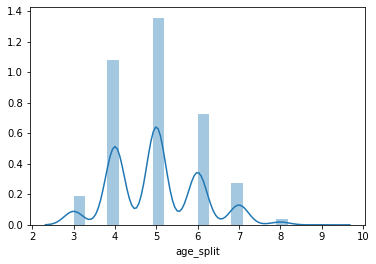

In [52]:
sns.distplot(df_player['age_split']) 

In [53]:
df_player['出身地域']= df_player['出身国']
df_player=df_player.replace({'出身地域':{'アメリカ':'北米','ドミニカ共和国':'北米','キューバ':'北米','台湾':'アジア','ベネズエラ':'北米','メキシコ':'北米','ブラジル':'北米','プエルトリコ':'北米','カナダ':'北米','アンティル':'北米','タイ':'アジア','オランダ':'北米','オーストラリア':'北米'}})
df_player.head(1)
#print(df.replace({'age': {24: 100, 18: 0}, 'point': {24: 50}}))

,No,年度,チームID,チーム名,選手ID,選手名,育成選手F,背番号,位置,投,打,身長,体重,生年月日,出身高校ID,出身高校名,出身大学ID,出身大学名,社会人,ドラフト年,ドラフト種別,ドラフト順位,年俸,出身国,出身地,血液型,経験年数,birth,age,age_split,経験年数_split,出身地域
0,0,2017,1,巨人,11343,相川 亮二,0,23,捕手,右,右,183,86,1976/7/11,30227,東京学館,0,不明,NaN,1994.0,NaN,5.0,4500,日本,千葉,A,23.0,1976,41,8,4.0,日本


In [54]:
df_player['BMI'] = df_player['体重']/(df_player['身長']/100)**2

In [55]:
df_player2 = df_player.drop(['チームID','チーム名','社会人','選手名','育成選手F','背番号','生年月日','出身高校ID','出身高校名','出身大学ID','出身大学名','ドラフト年','出身国','出身地','birth'],axis=1)
df_player2.head()

,No,年度,選手ID,位置,投,打,身長,体重,ドラフト種別,ドラフト順位,年俸,血液型,経験年数,age,age_split,経験年数_split,出身地域,BMI
0,0,2017,11343,捕手,右,右,183,86,NaN,5.0,4500,A,23.0,41,8,4.0,日本,25.680074
1,1,2017,11726,捕手,右,右,177,85,NaN,1.0,3700,A,19.0,37,7,3.0,日本,27.131412
2,2,2017,12049,内野手,右,左,180,97,NaN,1.0,26000,A,17.0,39,7,3.0,日本,29.938272
3,3,2017,12107,投手,左,左,175,82,NaN,3.0,5000,A,16.0,37,7,3.0,日本,26.775510
4,4,2017,12179,投手,右,右,184,94,NaN,1.0,7000,B,16.0,34,6,3.0,日本,27.764650


# PitchデータとPlayerデータをMerge

In [56]:
df_merge = pd.merge(df_pitch2,df_player2,left_on=['年度','投手ID'],right_on=['年度','選手ID'],how='left')
df_merge.head(1)

,データ内連番,球種,年度,試合ID,試合内連番,試合内投球数,日付,時刻,ホームチームID,アウェイチームID,球場ID,球場名,試合種別詳細,イニング,表裏,イニング内打席数,打席内投球数,投手ID,投手チームID,投手投球左右,投手役割,投手登板順,投手試合内対戦打者数,投手試合内投球数,投手イニング内投球数,打者ID,打者チームID,打者打席左右,打者打順,打者守備位置,打者試合内打席数,プレイ前ホームチーム得点数,プレイ前アウェイチーム得点数,プレイ前アウト数,プレイ前ボール数,プレイ前ストライク数,プレイ前走者状況,一塁走者ID,二塁走者ID,三塁走者ID,捕手ID,右翼手ID,成績対象投手ID,成績対象打者ID,count,pitch_team_score,month,start_ining,N,No,選手ID,位置,投,打,身長,体重,ドラフト種別,ドラフト順位,年俸,血液型,経験年数,age,age_split,経験年数_split,出身地域,BMI
0,0,0.0,2017,2017033101,1,1,2017-03-31,18:03:00,1,4,1,東京ドーム,セ・リーグ公式戦,1,表,1,1,1500001,1,右,先発,1,1,1,1,900410,4,左,1,中,1,0,0,0,0,0,___,NaN,NaN,NaN,1300027,900397,1500001,900410,0-0-0,0,3,1,1,59,1500001,投手,右,右,196,100,NaN,NaN,24000,不明,NaN,29,5,NaN,北米,26.03082


In [57]:
df_merge2 = df_merge.drop(['右翼手ID','No','位置','投','打','ドラフト種別','ドラフト順位','経験年数','経験年数_split','試合ID','日付','時刻','ホームチームID','アウェイチームID','球場ID','球場名','試合種別詳細','投手ID','投手チームID','打者チームID','プレイ前ホームチーム得点数','プレイ前アウェイチーム得点数','一塁走者ID','二塁走者ID','三塁走者ID','捕手ID','成績対象投手ID','成績対象打者ID','選手ID'],axis=1)
df_merge2.head(1)

,データ内連番,球種,年度,試合内連番,試合内投球数,イニング,表裏,イニング内打席数,打席内投球数,投手投球左右,投手役割,投手登板順,投手試合内対戦打者数,投手試合内投球数,投手イニング内投球数,打者ID,打者打席左右,打者打順,打者守備位置,打者試合内打席数,プレイ前アウト数,プレイ前ボール数,プレイ前ストライク数,プレイ前走者状況,count,pitch_team_score,month,start_ining,N,身長,体重,年俸,血液型,age,age_split,出身地域,BMI
0,0,0.0,2017,1,1,1,表,1,1,右,先発,1,1,1,1,900410,左,1,中,1,0,0,0,___,0-0-0,0,3,1,1,196,100,24000,不明,29,5,北米,26.03082


In [58]:
df_merge2 = df_merge2.rename(columns={'身長': 'P_身長','体重':'P_体重','年俸':'P_年俸','血液型':'P_血液型','age':'P_age','age_split':'P_age_split','出身地域':'P_出身地域','BMI':'P_BMI'})
df_merge2.head(1)

,データ内連番,球種,年度,試合内連番,試合内投球数,イニング,表裏,イニング内打席数,打席内投球数,投手投球左右,投手役割,投手登板順,投手試合内対戦打者数,投手試合内投球数,投手イニング内投球数,打者ID,打者打席左右,打者打順,打者守備位置,打者試合内打席数,プレイ前アウト数,プレイ前ボール数,プレイ前ストライク数,プレイ前走者状況,count,pitch_team_score,month,start_ining,N,P_身長,P_体重,P_年俸,P_血液型,P_age,P_age_split,P_出身地域,P_BMI
0,0,0.0,2017,1,1,1,表,1,1,右,先発,1,1,1,1,900410,左,1,中,1,0,0,0,___,0-0-0,0,3,1,1,196,100,24000,不明,29,5,北米,26.03082


In [59]:
df_merge3 = pd.merge(df_merge2,df_player2,left_on=['年度','打者ID'],right_on=['年度','選手ID'],how='left')
df_merge3.head(1)

,データ内連番,球種,年度,試合内連番,試合内投球数,イニング,表裏,イニング内打席数,打席内投球数,投手投球左右,投手役割,投手登板順,投手試合内対戦打者数,投手試合内投球数,投手イニング内投球数,打者ID,打者打席左右,打者打順,打者守備位置,打者試合内打席数,プレイ前アウト数,プレイ前ボール数,プレイ前ストライク数,プレイ前走者状況,count,pitch_team_score,month,start_ining,N,P_身長,P_体重,P_年俸,P_血液型,P_age,P_age_split,P_出身地域,P_BMI,No,選手ID,位置,投,打,身長,体重,ドラフト種別,ドラフト順位,年俸,血液型,経験年数,age,age_split,経験年数_split,出身地域,BMI
0,0,0.0,2017,1,1,1,表,1,1,右,先発,1,1,1,1,900410,左,1,中,1,0,0,0,___,0-0-0,0,3,1,1,196,100,24000,不明,29,5,北米,26.03082,262,900410,外野手,左,左,176,74,NaN,5.0,15000,A,8.0,32,6,1.0,日本,23.889463


In [60]:
df_merge4 = df_merge3.drop(['打者ID','No','選手ID','位置','投','打','ドラフト種別','ドラフト順位','経験年数','経験年数_split',],axis=1)
df_merge4.head(1)

,データ内連番,球種,年度,試合内連番,試合内投球数,イニング,表裏,イニング内打席数,打席内投球数,投手投球左右,投手役割,投手登板順,投手試合内対戦打者数,投手試合内投球数,投手イニング内投球数,打者打席左右,打者打順,打者守備位置,打者試合内打席数,プレイ前アウト数,プレイ前ボール数,プレイ前ストライク数,プレイ前走者状況,count,pitch_team_score,month,start_ining,N,P_身長,P_体重,P_年俸,P_血液型,P_age,P_age_split,P_出身地域,P_BMI,身長,体重,年俸,血液型,age,age_split,出身地域,BMI
0,0,0.0,2017,1,1,1,表,1,1,右,先発,1,1,1,1,左,1,中,1,0,0,0,___,0-0-0,0,3,1,1,196,100,24000,不明,29,5,北米,26.03082,176,74,15000,A,32,6,日本,23.889463


In [61]:
df_merge4 = df_merge4.rename(columns={'身長': 'B_身長','体重':'B_体重','年俸':'B_年俸','血液型':'B_血液型','age':'B_age','age_split':'B_age_split','出身地域':'B_出身地域','BMI':'B_BMI'})
df_merge4.head(1)

,データ内連番,球種,年度,試合内連番,試合内投球数,イニング,表裏,イニング内打席数,打席内投球数,投手投球左右,投手役割,投手登板順,投手試合内対戦打者数,投手試合内投球数,投手イニング内投球数,打者打席左右,打者打順,打者守備位置,打者試合内打席数,プレイ前アウト数,プレイ前ボール数,プレイ前ストライク数,プレイ前走者状況,count,pitch_team_score,month,start_ining,N,P_身長,P_体重,P_年俸,P_血液型,P_age,P_age_split,P_出身地域,P_BMI,B_身長,B_体重,B_年俸,B_血液型,B_age,B_age_split,B_出身地域,B_BMI
0,0,0.0,2017,1,1,1,表,1,1,右,先発,1,1,1,1,左,1,中,1,0,0,0,___,0-0-0,0,3,1,1,196,100,24000,不明,29,5,北米,26.03082,176,74,15000,A,32,6,日本,23.889463


In [62]:
df_test_merge = df_merge4[df_merge2['球種'].isnull()].drop(['球種'],axis=1).reset_index(drop = True)
df_train_merge = df_merge4.dropna(subset=['球種'])
df_test_merge.head(1)

,データ内連番,年度,試合内連番,試合内投球数,イニング,表裏,イニング内打席数,打席内投球数,投手投球左右,投手役割,投手登板順,投手試合内対戦打者数,投手試合内投球数,投手イニング内投球数,打者打席左右,打者打順,打者守備位置,打者試合内打席数,プレイ前アウト数,プレイ前ボール数,プレイ前ストライク数,プレイ前走者状況,count,pitch_team_score,month,start_ining,N,P_身長,P_体重,P_年俸,P_血液型,P_age,P_age_split,P_出身地域,P_BMI,B_身長,B_体重,B_年俸,B_血液型,B_age,B_age_split,B_出身地域,B_BMI
0,0,2018,1,1,1,表,1,1,右,先発,1,1,1,1,左,1,中,1,0,0,0,___,0-0-0,0,3,1,1,186,92,45000,A,29,5,日本,26.59267,181,89,3800,O,25,5,日本,27.166448


In [66]:
pd.to_pickle(df_merge4,'../yakiu_rawdata/df_merge.pkl')
pd.to_pickle(df_test_merge,'../yakiu_rawdata/df_test_merge.pkl')
pd.to_pickle(df_train_merge,'../yakiu_rawdata/adf_train_merge.pkl')

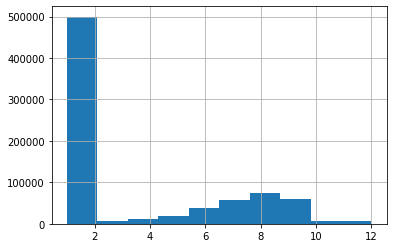

In [65]:
df_merge4['start_ining'].hist()